### Exemplo de teste de hipótese com Bootstraping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

random.seed(190)

mu = 300
delta_mu_tratamento = 10
sigma = 100
N=250

# Imagine um experimento com os seguintes resultados:
controle= np.random.normal(mu, sigma, N)
tratamento= np.random.normal(mu + delta_mu_tratamento, sigma, N)

In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# A média do controle
media_controle_observada = controle.mean()
media_controle_observada

299.2829001553272

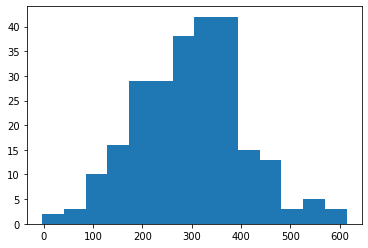

In [3]:
_ = plt.hist(controle, bins='auto')
plt.show()

In [4]:
# A média do tratamento
media_tratamento_observada = tratamento.mean()
media_tratamento_observada

309.59448594632914

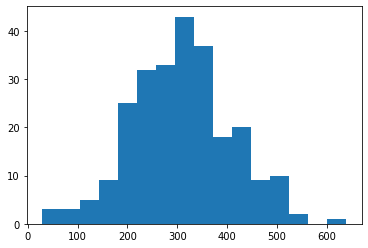

In [5]:
_ = plt.hist(tratamento, bins='auto')
plt.show()

In [6]:
# Será que essa diferença de médias observadas é significativa?
diff_medias = media_tratamento_observada - media_controle_observada
diff_medias

10.31158579100196

#### Teste de Hipótese

Iremos testar se o tratamento é maior que o controle (teste unicaudal)

In [7]:
# Tamanho dos vetores tratamento e controle
n_controle = len(controle)
n_tratamento = len(tratamento)

# Concatenando os vetores para ter uma única distribuição
distribuicao_unica = np.concatenate((controle, tratamento))

In [8]:
# Aqui são realizadas as simulações para o cálculo do p-valor. 

n_simulacoes = 100000
vetor_diferenca_medias = [None]*n_simulacoes

for ii in range(0,n_simulacoes):
    
    simul_controle = np.random.choice(distribuicao_unica, n_controle, replace=True)
    simul_tratamento = np.random.choice(distribuicao_unica, n_tratamento, replace=True)
    vetor_diferenca_medias[ii]= simul_tratamento.mean() - simul_controle.mean()    

Ao concatenarmos os vetores de tratamento e controle e pegarmos valores aleatórios dentro dessa nova distribuição, estamos simulando o caso em que a hipótese nula é verdadeira, ou seja, de fato os dois grupos são iguais

O vetor_diferenca_medias contém a diferença de médias observadas na simulação, sob a hipótese que os dois vetores (tratamento e controle) são iguais.

Abaixo, o histograma do vetor de diferenças da simulação. 
- Note que os valores estão concentrados ao redor de 0 (o que é esperado, dado que fizemos samples da mesma distribuição)
- Repare na dispersão dos dados

Apenas olhando para esta distribuição, tente responder: você acha que a diferença de médias observadas entre o controle e tratamento inicial é significativa? Qual parece ser a chance de esse valor ter sido gerado por distribuições de tratamento e controle iguais (hipótese nula)?


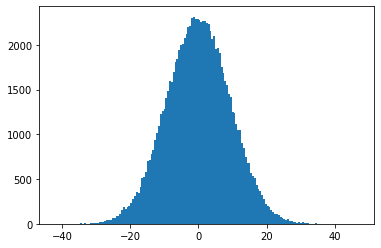

In [9]:
_ = plt.hist(vetor_diferenca_medias, bins='auto')
plt.show()

O p-valor é justamente a chance de obter valores mais extremos sob a hipótese nula.

In [10]:
# A quantidade de vezes que foi obtido valores tão ou mais extremos foi:
n_extremos_gt = len(np.where(vetor_diferenca_medias >= abs(diff_medias))[0])
n_extremos_lt = len(np.where(vetor_diferenca_medias <= -abs(diff_medias))[0])

n_extremos = n_extremos_gt + n_extremos_lt
n_extremos

27147

In [11]:
diff_medias

10.31158579100196

In [12]:
# Para cálculos monocaudal, não utilizamos o valos absoluto!
# Greater
n_extremos_greater = len(np.where(vetor_diferenca_medias >= (diff_medias))[0])
n_extremos_greater

13465

In [13]:
n_extremos_less = len(np.where(vetor_diferenca_medias <= (diff_medias))[0])
n_extremos_less

86535

### Comparando p-valor do bootstrapping com t-test

#### Bicaudal

In [14]:
treat_pvalue = lambda x: round(100*x, 1)

# P valor é a chance de obter valores tão ou mais extremos que o observado, tanto para mais quando para menos:
pvalor_boot_2_sided = treat_pvalue(n_extremos/ n_simulacoes)
pvalor_boot_2_sided

27.1

In [15]:
# Usando a função t_test
t2, pvalor_ttest_2_sided = stats.ttest_ind(tratamento, controle, equal_var = False, alternative = 'two-sided')
pvalor_ttest_2_sided = treat_pvalue(pvalor_ttest_2_sided)
pvalor_ttest_2_sided


27.0

#### Monocaudal: Less

In [16]:
pvalor_boot_less = treat_pvalue(n_extremos_less/ n_simulacoes)
pvalor_boot_less

86.5

In [17]:
# Exemplo de one-sided (less)
t2, pvalor_ttest_less = stats.ttest_ind(tratamento, controle, equal_var = True, alternative = 'less')
pvalor_ttest_less = treat_pvalue(pvalor_ttest_less)
pvalor_ttest_less

86.5

#### Monocaudal: Greater

In [18]:
pvalor_boot_greater = treat_pvalue(n_extremos_greater/ n_simulacoes)
pvalor_boot_greater

13.5

In [19]:
t2, pvalor_ttest_greater = stats.ttest_ind(tratamento, controle, equal_var = True, alternative = 'greater')
pvalor_ttest_greater = treat_pvalue(pvalor_ttest_greater)
pvalor_ttest_greater

13.5

### Comparando com resultados de diff-in-diff

In [20]:
# Assumindo que ambos os sinais tinham o mesmo comportamento antes da intervenção
df_control_pre = pd.DataFrame.from_dict({'post': [0]*N, 'treat': [0]*N, 'value': np.random.normal(mu, sigma, N)})
df_treat_pre = pd.DataFrame.from_dict({'post': [0]*N, 'treat': [1]*N, 'value': np.random.normal(mu, sigma, N)})

df_control_post = pd.DataFrame.from_dict({'post': [1]*N, 'treat': [0]*N, 'value': controle})
df_treat_post = pd.DataFrame.from_dict({'post': [1]*N, 'treat': [1]*N, 'value': tratamento})

In [21]:
df = df_control_pre.append(df_treat_pre).append(df_control_post).append(df_treat_post)
df = df.reset_index(drop = True)
df['post_treat'] = df['post'] * df['treat']
df

,post,treat,value,post_treat
0,0,0,400.199405,0
1,0,0,305.203425,0
2,0,0,193.244844,0
3,0,0,112.730827,0
4,0,0,178.681817,0
...,...,...,...,...
995,1,1,242.682396,1
996,1,1,382.517948,1
997,1,1,336.601305,1
998,1,1,288.770646,1


In [22]:
smf.ols('value ~ post_treat', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,297.2470,3.644,81.578,0.000,290.097,304.397
post_treat,12.3475,7.287,1.694,0.091,-1.953,26.648


In [23]:
smf.ols('value ~ post*treat', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,296.1384,6.317,46.880,0.000,283.742,308.534
post,3.1445,8.934,0.352,0.725,-14.386,20.675
treat,0.1812,8.934,0.020,0.984,-17.349,17.712
post:treat,10.1304,12.634,0.802,0.423,-14.662,34.923


In [24]:
diff_medias

10.31158579100196

In [25]:
pvalor_boot_greater 

13.5

Para um video introdutório sobre teste de hipótese usando bootstrapping, veja: https://www.youtube.com/watch?v=isEcgoCmlO0